In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import mygene
import os
pd.set_option('display.max_columns', None)


In [19]:
# Set the working directory
working_dir = "/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Snords"
os.chdir(working_dir)
print(f"Current working directory: {os.getcwd()}")

Current working directory: /beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Snords


# Local functions

In [20]:
def check_dexseq_results(results_file: str, output_dir: str = "qc_plots"):
    """
    Perform quality checks on DEXSeq results file.
    
    Args:
        results_file: Path to DEXSeq results CSV file
        output_dir: Directory to save QC plots
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Load results
    print("Loading results file...")
    df = pd.read_csv(results_file)
    
    # Basic statistics
    print("\n=== Basic Statistics ===")
    print(f"Total number of tests: {len(df)}")
    print(f"Number of NA p-values: {df['pvalue'].isna().sum()}")
    print(f"Number of NA adjusted p-values: {df['padj'].isna().sum()}")
    print(f"Number of significant results (padj < 0.05): {(df['padj'] < 0.05).sum()}")
    print(f"Number of significant results (padj < 0.1): {(df['padj'] < 0.1).sum()}")
    
    # Check for extreme fold changes
    fc_stats = df['log2fold_treated_control'].describe()
    print("\n=== Fold Change Statistics ===")
    print(fc_stats)
    
    # Identify potential problematic results
    print("\n=== Potential Issues ===")
    problematic = df[
        (df['log2fold_treated_control'].abs() > 5) |  # Extreme fold changes
        (df['dispersion'] > 10) |                     # High dispersion
        (df['pvalue'].isna()) |                      # Missing p-values
        (df['stat'].abs() > 10000)                   # Extreme test statistics
    ]
    print(f"Number of potentially problematic results: {len(problematic)}")
    if len(problematic) > 0:
        print("\nSample of problematic results:")
        print(problematic[['groupID', 'featureID', 'log2fold_treated_control', 'dispersion', 'pvalue', 'stat']].head())
    
    # Create plots
    plt.style.use('default')
    
    # 1. P-value distribution
    plt.figure(figsize=(10, 6))
    plt.hist(df['pvalue'].dropna(), bins=50, edgecolor='black')
    plt.title('P-value Distribution')
    plt.xlabel('P-value')
    plt.ylabel('Frequency')
    plt.savefig(f"{output_dir}/pvalue_distribution.png")
    plt.close()
    
    # 2. Volcano plot
    plt.figure(figsize=(10, 6))
    plt.scatter(df['log2fold_treated_control'], 
               -np.log10(df['pvalue']),
               alpha=0.5)
    plt.title('Volcano Plot')
    plt.xlabel('Log2 Fold Change')
    plt.ylabel('-log10(p-value)')
    plt.savefig(f"{output_dir}/volcano_plot.png")
    plt.close()
    
    # 3. MA plot
    plt.figure(figsize=(10, 6))
    plt.scatter(df['exonBaseMean'],
               df['log2fold_treated_control'],
               alpha=0.5)
    plt.xscale('log')
    plt.title('MA Plot')
    plt.xlabel('Mean Expression')
    plt.ylabel('Log2 Fold Change')
    plt.savefig(f"{output_dir}/ma_plot.png")
    plt.close()
    
    # 4. Dispersion plot
    plt.figure(figsize=(10, 6))
    plt.scatter(df['exonBaseMean'],
               df['dispersion'],
               alpha=0.5)
    plt.xscale('log')
    plt.yscale('log')
    plt.title('Dispersion Plot')
    plt.xlabel('Mean Expression')
    plt.ylabel('Dispersion')
    plt.savefig(f"{output_dir}/dispersion_plot.png")
    plt.close()
    
    # Check for the problematic gene/exon mentioned in the error
    problem_genes = ['ENSG00000285404.1', 'ENSG00000100150.19', 
                    'ENSG00000128245.15', 'ENSG00000252909.1']
    
    print("\n=== Checking Problematic Genes ===")
    for gene in problem_genes:
        gene_results = df[df['groupID'].str.contains(gene, na=False)]
        if len(gene_results) > 0:
            print(f"\nResults for {gene}:")
            print(gene_results[['featureID', 'log2fold_treated_control', 
                              'pvalue', 'padj', 'dispersion']].head())
    
    # Save problematic results to file
    if len(problematic) > 0:
        problematic.to_csv(f"{output_dir}/problematic_results.csv")
        print(f"\nProblematic results saved to {output_dir}/problematic_results.csv")
    
    # Return summary statistics
    return {
        'total_tests': len(df),
        'significant_005': (df['padj'] < 0.05).sum(),
        'significant_01': (df['padj'] < 0.1).sum(),
        'na_pvalues': df['pvalue'].isna().sum(),
        'problematic_count': len(problematic),
        'median_dispersion': df['dispersion'].median(),
        'median_fold_change': df['log2fold_treated_control'].median()
    }

# Examind the data

In [21]:
# Example usage
results_file = "output/dexseq_results_PW1_vs_combined_controls.csv"
df = pd.read_csv(results_file)

In [22]:
df.head()

,Unnamed: 0,groupID,featureID,exonBaseMean,dispersion,stat,pvalue,padj,control,treated,log2fold_treated_control,genomicData.seqnames,genomicData.start,genomicData.end,genomicData.width,genomicData.strand,countData.EDO_1,countData.EDO_2,countData.EDO_3,countData.ND1_1,countData.ND1_2,countData.ND1_3,countData.PW1_1,countData.PW1_2,countData.PW1_3
0,ENSG00000000003.14:E001,ENSG00000000003.14,E001,120.179059,0.011335,2984.629607,0.000000e+00,0.000000e+00,16.638651,14.784409,-0.479628,chrX,100627109,100628669,1561,-,123,139,86,83,106,98,119,182,189
1,ENSG00000000003.14:E002,ENSG00000000003.14,E002,1270.531715,0.006461,396.260920,8.975001e-87,1.213046e-86,30.813401,30.602511,-0.045605,chrX,100628670,100629986,1317,-,1007,1237,687,906,1184,974,1419,2630,2220
2,ENSG00000000003.14:E003,ENSG00000000003.14,E003,444.716283,0.008585,1806.024855,0.000000e+00,0.000000e+00,23.933712,23.706313,-0.051117,chrX,100630759,100630866,108,-,375,434,254,277,397,359,471,926,802
3,ENSG00000000003.14:E004,ENSG00000000003.14,E004,1.981576,0.022925,3109.695893,0.000000e+00,0.000000e+00,2.492781,2.656301,0.185495,chrX,100632063,100632068,6,-,1,2,1,1,4,0,2,5,4
4,ENSG00000000003.14:E005,ENSG00000000003.14,E005,358.929210,0.007125,2538.819848,0.000000e+00,0.000000e+00,22.574929,22.337963,-0.053991,chrX,100632485,100632568,84,-,289,347,196,233,334,297,393,719,654


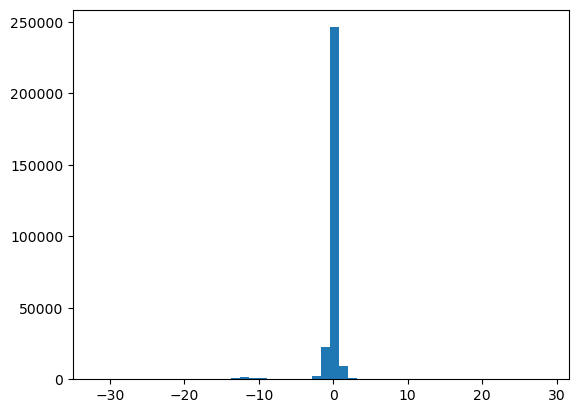

In [23]:
hist = plt.hist(df['log2fold_treated_control'], bins=50)


In [24]:
summary_stats = check_dexseq_results(results_file)

Loading results file...

=== Basic Statistics ===
Total number of tests: 290520
Number of NA p-values: 0
Number of NA adjusted p-values: 0
Number of significant results (padj < 0.05): 287297
Number of significant results (padj < 0.1): 287832

=== Fold Change Statistics ===
count    290432.000000
mean         -0.168433
std           1.957209
min         -31.908590
25%          -0.154926
50%          -0.004989
75%           0.147049
max          28.618847
Name: log2fold_treated_control, dtype: float64

=== Potential Issues ===
Number of potentially problematic results: 20155

Sample of problematic results:
                groupID featureID  log2fold_treated_control  dispersion  \
45   ENSG00000000460.17      E001                 -8.061519    0.135117   
213  ENSG00000001617.12      E023                -11.586685    0.030460   
214  ENSG00000001617.12      E024                -11.586685    0.030460   
285  ENSG00000002330.13      E010                -10.580658    0.086691   
286  ENSG0000

/home/kubacki.michal/.conda/envs/jupyter_nb/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)



=== Checking Problematic Genes ===

Results for ENSG00000285404.1:
       featureID  log2fold_treated_control         pvalue           padj  \
286350      E001                       NaN   0.000000e+00   0.000000e+00   
286351      E002                       NaN   0.000000e+00   0.000000e+00   
286352      E003                       NaN   0.000000e+00   0.000000e+00   
286353      E004                       NaN  2.568590e-306  5.283282e-306   
286354      E005                       NaN  8.544953e-182  1.406783e-181   

        dispersion  
286350    0.062429  
286351    0.071076  
286352    0.071076  
286353    0.081908  
286354    0.153038  

Results for ENSG00000100150.19:
       featureID  log2fold_treated_control         pvalue           padj  \
286350      E001                       NaN   0.000000e+00   0.000000e+00   
286351      E002                       NaN   0.000000e+00   0.000000e+00   
286352      E003                       NaN   0.000000e+00   0.000000e+00   
286353      

In [25]:
# Print summary
print("\n=== Analysis Summary ===")
for key, value in summary_stats.items():
    print(f"{key}: {value}")


=== Analysis Summary ===
total_tests: 290520
significant_005: 287297
significant_01: 287832
na_pvalues: 0
problematic_count: 20155
median_dispersion: 0.02005845463844835
median_fold_change: -0.0049886364337101


# Select significant results

In [26]:
df_sig = df[df['padj'] < 0.05]

In [27]:
print(df.shape)
print(df_sig.shape)

(290520, 25)
(287297, 25)


In [28]:
df = df_sig

# Remove overlapping genes

In [49]:
df[df['groupID'].str.contains('\+')].head()

,Unnamed: 0,groupID,featureID,exonBaseMean,dispersion,stat,pvalue,padj,control,treated,log2fold_treated_control,genomicData.seqnames,genomicData.start,genomicData.end,genomicData.width,genomicData.strand,countData.EDO_1,countData.EDO_2,countData.EDO_3,countData.ND1_1,countData.ND1_2,countData.ND1_3,countData.PW1_1,countData.PW1_2,countData.PW1_3
598,ENSG00000004139.14+ENSG00000258924.4+ENSG00000...,ENSG00000004139.14+ENSG00000258924.4+ENSG00000...,E001,193.932051,0.006731,3484.434614,0.0,0.0,18.276850,18.739936,0.111862,chr17,28357647,28357881,235,+,133,163,135,168,213,188,206,349,266
599,ENSG00000004139.14+ENSG00000258924.4+ENSG00000...,ENSG00000004139.14+ENSG00000258924.4+ENSG00000...,E002,42.295721,0.004764,7453.821768,0.0,0.0,10.351660,10.557982,0.067679,chr17,28358043,28358468,426,+,30,52,36,35,35,32,42,63,70
600,ENSG00000004139.14+ENSG00000258924.4+ENSG00000...,ENSG00000004139.14+ENSG00000258924.4+ENSG00000...,E003,166.406287,0.005400,4513.573292,0.0,0.0,17.661403,17.294832,-0.090493,chr17,28358916,28358989,74,+,121,159,131,136,182,171,165,270,207
601,ENSG00000004139.14+ENSG00000258924.4+ENSG00000...,ENSG00000004139.14+ENSG00000258924.4+ENSG00000...,E004,187.816167,0.007337,3290.410685,0.0,0.0,18.302647,18.175322,-0.030921,chr17,28359315,28359404,90,+,122,169,138,179,210,186,186,311,250
602,ENSG00000004139.14+ENSG00000258924.4+ENSG00000...,ENSG00000004139.14+ENSG00000258924.4+ENSG00000...,E005,98.483869,0.004650,6195.297761,0.0,0.0,14.715918,14.385957,-0.088547,chr17,28360529,28360571,43,+,68,92,69,97,117,93,96,158,128


In [50]:
df = df[~df['groupID'].str.contains('\+')]

In [51]:
df.head()

,Unnamed: 0,groupID,featureID,exonBaseMean,dispersion,stat,pvalue,padj,control,treated,log2fold_treated_control,genomicData.seqnames,genomicData.start,genomicData.end,genomicData.width,genomicData.strand,countData.EDO_1,countData.EDO_2,countData.EDO_3,countData.ND1_1,countData.ND1_2,countData.ND1_3,countData.PW1_1,countData.PW1_2,countData.PW1_3
0,ENSG00000000003.14:E001,ENSG00000000003.14,E001,120.179059,0.011335,2984.629607,0.000000e+00,0.000000e+00,16.638651,14.784409,-0.479628,chrX,100627109,100628669,1561,-,123,139,86,83,106,98,119,182,189
1,ENSG00000000003.14:E002,ENSG00000000003.14,E002,1270.531715,0.006461,396.260920,8.975001e-87,1.213046e-86,30.813401,30.602511,-0.045605,chrX,100628670,100629986,1317,-,1007,1237,687,906,1184,974,1419,2630,2220
2,ENSG00000000003.14:E003,ENSG00000000003.14,E003,444.716283,0.008585,1806.024855,0.000000e+00,0.000000e+00,23.933712,23.706313,-0.051117,chrX,100630759,100630866,108,-,375,434,254,277,397,359,471,926,802
3,ENSG00000000003.14:E004,ENSG00000000003.14,E004,1.981576,0.022925,3109.695893,0.000000e+00,0.000000e+00,2.492781,2.656301,0.185495,chrX,100632063,100632068,6,-,1,2,1,1,4,0,2,5,4
4,ENSG00000000003.14:E005,ENSG00000000003.14,E005,358.929210,0.007125,2538.819848,0.000000e+00,0.000000e+00,22.574929,22.337963,-0.053991,chrX,100632485,100632568,84,-,289,347,196,233,334,297,393,719,654


# Select problematic genes

In [52]:
# List of problematic genes from the error message
problematic_genes = ['ENSG00000285404.1', 'ENSG00000100150.19', 
                    'ENSG00000128245.15', 'ENSG00000252909.1']

# Create masks for each condition
extreme_fc_mask = (df['log2fold_treated_control'].abs() > 5)
high_disp_mask = (df['dispersion'] > 10)
missing_vals_mask = (
    df['log2fold_treated_control'].isna() |
    df['pvalue'].isna() |
    df['padj'].isna()
)
extreme_stat_mask = (df['stat'].abs() > 10000)
problematic_genes_mask = df['groupID'].str.contains('|'.join(problematic_genes), regex=True)

# Print counts for each condition
print(f"Records with extreme fold changes (>5): {extreme_fc_mask.sum()}")
print(f"Records with high dispersion (>10): {high_disp_mask.sum()}")
print(f"Records with missing values: {missing_vals_mask.sum()}")
print(f"Records with extreme test statistics (>10000): {extreme_stat_mask.sum()}")
print(f"Records from problematic genes: {problematic_genes_mask.sum()}")

Records with extreme fold changes (>5): 6068
Records with high dispersion (>10): 0
Records with missing values: 0
Records with extreme test statistics (>10000): 10028
Records from problematic genes: 0


In [53]:
df.columns

Index(['Unnamed: 0', 'groupID', 'featureID', 'exonBaseMean', 'dispersion',
       'stat', 'pvalue', 'padj', 'control', 'treated',
       'log2fold_treated_control', 'genomicData.seqnames', 'genomicData.start',
       'genomicData.end', 'genomicData.width', 'genomicData.strand',
       'countData.EDO_1', 'countData.EDO_2', 'countData.EDO_3',
       'countData.ND1_1', 'countData.ND1_2', 'countData.ND1_3',
       'countData.PW1_1', 'countData.PW1_2', 'countData.PW1_3'],
      dtype='object')

# Examine extreme test statistics

In [34]:
# Print genes with extreme test statistics
print(list(df[extreme_stat_mask]['groupID'].unique()))
df[extreme_stat_mask].head()


['ENSG00000003393.15', 'ENSG00000003756.16', 'ENSG00000004142.12', 'ENSG00000004487.16', 'ENSG00000004534.15', 'ENSG00000005483.21', 'ENSG00000005486.17', 'ENSG00000005810.18', 'ENSG00000006576.16', 'ENSG00000006625.18+ENSG00000281039.1+ENSG00000196295.12+ENSG00000244480.1', 'ENSG00000006704.10', 'ENSG00000007202.15', 'ENSG00000007392.16', 'ENSG00000008710.19+ENSG00000284008.1', 'ENSG00000009335.18', 'ENSG00000009413.15', 'ENSG00000009954.11', 'ENSG00000010322.16', 'ENSG00000011007.12', 'ENSG00000011523.14', 'ENSG00000011566.15', 'ENSG00000012174.12+ENSG00000206639.1', 'ENSG00000022840.16', 'ENSG00000033170.16', 'ENSG00000034053.14', 'ENSG00000037474.15', 'ENSG00000038219.13', 'ENSG00000038382.20', 'ENSG00000038532.16', 'ENSG00000040933.15', 'ENSG00000044115.21', 'ENSG00000047056.15', 'ENSG00000047188.16', 'ENSG00000048828.17', 'ENSG00000050165.17', 'ENSG00000050405.13', 'ENSG00000051825.14', 'ENSG00000052126.14', 'ENSG00000054267.22', 'ENSG00000054523.17+ENSG00000264501.2', 'ENSG00000

,Unnamed: 0,groupID,featureID,exonBaseMean,dispersion,stat,pvalue,padj,control,treated,log2fold_treated_control,genomicData.seqnames,genomicData.start,genomicData.end,genomicData.width,genomicData.strand,countData.EDO_1,countData.EDO_2,countData.EDO_3,countData.ND1_1,countData.ND1_2,countData.ND1_3,countData.PW1_1,countData.PW1_2,countData.PW1_3
453,ENSG00000003393.15:E003,ENSG00000003393.15,E003,181.164947,0.001974,14198.396557,0.0,0.0,18.004557,17.806407,-0.048457,chr2,201704454,201704603,150,-,169,178,127,153,225,172,162,267,227
454,ENSG00000003393.15:E004,ENSG00000003393.15,E004,170.332407,0.001905,14819.648036,0.0,0.0,17.524447,17.697276,0.042537,chr2,201705139,201705200,62,-,165,176,120,141,204,138,157,254,233
455,ENSG00000003393.15:E005,ENSG00000003393.15,E005,134.660145,0.002467,13040.469603,0.0,0.0,16.236318,16.205474,-0.007857,chr2,201705416,201705461,46,-,127,138,97,106,174,113,124,198,175
456,ENSG00000003393.15:E006,ENSG00000003393.15,E006,165.129303,0.002879,10972.388415,0.0,0.0,17.418973,17.322242,-0.023938,chr2,201706846,201707022,177,-,153,160,121,131,213,149,154,232,217
457,ENSG00000003393.15:E007,ENSG00000003393.15,E007,112.260910,0.002282,14404.573893,0.0,0.0,15.233883,15.167037,-0.017551,chr2,201707869,201707991,123,-,99,112,71,102,142,105,107,152,153


In [54]:
df.sort_values('stat', ascending=False)[:10]

,Unnamed: 0,groupID,featureID,exonBaseMean,dispersion,stat,pvalue,padj,control,treated,log2fold_treated_control,genomicData.seqnames,genomicData.start,genomicData.end,genomicData.width,genomicData.strand,countData.EDO_1,countData.EDO_2,countData.EDO_3,countData.ND1_1,countData.ND1_2,countData.ND1_3,countData.PW1_1,countData.PW1_2,countData.PW1_3
70073,ENSG00000115306.16:E039,ENSG00000115306.16,E039,554.447861,0.000492,81053.002685,0.0,0.0,24.850466,24.477755,-0.083190,chr2,54660000,54662308,2309,+,548,611,415,584,610,510,453,678,667
70066,ENSG00000115306.16:E032,ENSG00000115306.16,E032,1686.199895,0.000390,72334.393627,0.0,0.0,31.978087,32.322182,0.074098,chr2,54649615,54649989,375,+,1630,1727,1210,1709,1819,1552,1464,2234,2205
70060,ENSG00000115306.16:E026,ENSG00000115306.16,E026,706.107051,0.000565,69262.953444,0.0,0.0,26.404620,26.063159,-0.075376,chr2,54645928,54646017,90,+,751,769,526,692,757,666,601,848,843
70054,ENSG00000115306.16:E020,ENSG00000115306.16,E020,972.963998,0.000524,67968.210820,0.0,0.0,28.427973,28.407289,-0.004513,chr2,54637713,54637803,91,+,988,991,707,942,1123,911,831,1224,1222
70051,ENSG00000115306.16:E017,ENSG00000115306.16,E017,1047.378599,0.000631,57151.980259,0.0,0.0,28.809092,29.078244,0.058587,chr2,54629892,54630029,138,+,1008,1027,796,1049,1115,993,946,1311,1363
70064,ENSG00000115306.16:E030,ENSG00000115306.16,E030,525.997748,0.000775,57110.277560,0.0,0.0,24.205449,24.844963,0.142901,chr2,54649185,54649190,6,+,470,513,376,513,593,501,455,728,723
70036,ENSG00000115306.16:E002,ENSG00000115306.16,E002,174.560322,0.000987,55556.682793,0.0,0.0,17.429007,17.802758,0.091980,chr2,54456327,54456518,192,+,192,165,130,171,177,155,165,241,207
70061,ENSG00000115306.16:E027,ENSG00000115306.16,E027,886.828697,0.000700,54952.774844,0.0,0.0,27.797869,27.826656,0.006299,chr2,54646194,54646475,282,+,803,958,662,885,1021,818,774,1136,1089
70047,ENSG00000115306.16:E013,ENSG00000115306.16,E013,715.790539,0.000773,53478.032981,0.0,0.0,26.228287,26.784389,0.122553,chr2,54624804,54624962,159,+,697,737,544,699,717,652,598,1038,935
85984,ENSG00000125107.18:E018,ENSG00000125107.18,E018,268.088549,0.000624,50356.940321,0.0,0.0,20.466526,20.320257,-0.034214,chr16,58542231,58542335,105,-,243,269,185,248,288,217,261,416,378


In [67]:
n_sel = 100 
stat_sel = list(df.sort_values('stat', ascending=False)[:n_sel]['groupID'][~df.sort_values('stat', ascending=False)[:n_sel]['groupID'].str.contains('\+')].unique())
print(stat_sel)


['ENSG00000115306.16', 'ENSG00000125107.18', 'ENSG00000132466.18', 'ENSG00000151914.20', 'ENSG00000155511.18', 'ENSG00000005810.18', 'ENSG00000115464.14', 'ENSG00000038382.20', 'ENSG00000103657.14', 'ENSG00000113594.10', 'ENSG00000197535.14', 'ENSG00000144357.16']


In [60]:
# Initialize mygene client
mg = mygene.MyGeneInfo()

# Remove version numbers from ENSEMBL IDs
stat_sel_no_version = [id.split('.')[0] for id in stat_sel]

# Query the gene symbols
results = mg.querymany(stat_sel_no_version, scopes='ensembl.gene', fields='symbol', species='human')

# Create a dictionary mapping ENSEMBL IDs to symbols
gene_map = {res['query']: res.get('symbol', 'Not found') for res in results}

gene_symbols = [gene_map[ensembl_id.split('.')[0]] for ensembl_id in stat_sel]

ensembl_to_symbol = dict(zip(stat_sel, gene_symbols))

# Print results
for ensembl, symbol in ensembl_to_symbol.items():
    print(f"{ensembl}: {symbol}")

ENSG00000115306.16: SPTBN1
ENSG00000125107.18: CNOT1
ENSG00000132466.18: ANKRD17
ENSG00000151914.20: DST
ENSG00000155511.18: GRIA1
ENSG00000005810.18: MYCBP2
ENSG00000115464.14: USP34
ENSG00000038382.20: TRIO
ENSG00000103657.14: HERC1
ENSG00000113594.10: LIFR
ENSG00000197535.14: MYO5A
ENSG00000144357.16: UBR3


In [37]:
# Examine records with extreme test statistics
extreme_stat_records = df[extreme_stat_mask][['groupID', 'featureID', 'stat', 'pvalue', 'padj', 'log2fold_treated_control', 'dispersion']]
print("\nSample of records with extreme test statistics:")
extreme_stat_records.head()



Sample of records with extreme test statistics:


,groupID,featureID,stat,pvalue,padj,log2fold_treated_control,dispersion
453,ENSG00000003393.15,E003,14198.396557,0.0,0.0,-0.048457,0.001974
454,ENSG00000003393.15,E004,14819.648036,0.0,0.0,0.042537,0.001905
455,ENSG00000003393.15,E005,13040.469603,0.0,0.0,-0.007857,0.002467
456,ENSG00000003393.15,E006,10972.388415,0.0,0.0,-0.023938,0.002879
457,ENSG00000003393.15,E007,14404.573893,0.0,0.0,-0.017551,0.002282


- log2fold change is tiny: 0.042537 (about 3% increase)
- Very low dispersion: 0.001905
- High stat value: 14819.648036
- This means: The change is small, but it's happening very consistently across all replicates

## Examine extreme fold changes

In [61]:
# Print genes with extreme fold changes
print(list(df[extreme_fc_mask]['groupID'].unique()))
df[extreme_fc_mask].head()

['ENSG00000000460.17', 'ENSG00000001617.12', 'ENSG00000002330.13', 'ENSG00000002726.20', 'ENSG00000003400.14', 'ENSG00000003436.16', 'ENSG00000003989.17', 'ENSG00000004961.15', 'ENSG00000005187.12', 'ENSG00000005194.15', 'ENSG00000005238.19', 'ENSG00000005471.17', 'ENSG00000005801.18', 'ENSG00000005981.13', 'ENSG00000006071.14', 'ENSG00000006327.13', 'ENSG00000006530.18', 'ENSG00000007237.18', 'ENSG00000007952.18', 'ENSG00000008086.11', 'ENSG00000008323.15', 'ENSG00000009709.12', 'ENSG00000009724.16', 'ENSG00000010278.14', 'ENSG00000010295.19', 'ENSG00000010327.10', 'ENSG00000010379.16', 'ENSG00000010438.16', 'ENSG00000010671.15', 'ENSG00000010704.18', 'ENSG00000011083.9', 'ENSG00000011105.14', 'ENSG00000011243.18', 'ENSG00000011465.17', 'ENSG00000011566.15', 'ENSG00000012504.15', 'ENSG00000016602.9', 'ENSG00000017483.15', 'ENSG00000019582.15', 'ENSG00000022355.17', 'ENSG00000022556.16', 'ENSG00000023191.17', 'ENSG00000023330.15', 'ENSG00000023445.14', 'ENSG00000024526.17', 'ENSG000000

,Unnamed: 0,groupID,featureID,exonBaseMean,dispersion,stat,pvalue,padj,control,treated,log2fold_treated_control,genomicData.seqnames,genomicData.start,genomicData.end,genomicData.width,genomicData.strand,countData.EDO_1,countData.EDO_2,countData.EDO_3,countData.ND1_1,countData.ND1_2,countData.ND1_3,countData.PW1_1,countData.PW1_2,countData.PW1_3
45,ENSG00000000460.17:E001,ENSG00000000460.17,E001,0.108834,0.135117,619.693208,2.724768e-135,4.092900e-135,0.731564,0.044780,-8.061519,chr1,169794730,169794905,176,+,0,1,0,0,0,0,0,0,0
213,ENSG00000001617.12:E023,ENSG00000001617.12,E023,0.954954,0.030460,1688.055304,0.000000e+00,0.000000e+00,1.686926,0.030495,-11.586685,chr3,50189074,50189074,1,+,0,2,4,1,0,0,0,0,0
214,ENSG00000001617.12:E024,ENSG00000001617.12,E024,0.954954,0.030460,1688.055304,0.000000e+00,0.000000e+00,1.686926,0.030495,-11.586685,chr3,50189075,50189075,1,+,0,2,4,1,0,0,0,0,0
285,ENSG00000002330.13:E010,ENSG00000002330.13,E010,0.352526,0.086691,942.946676,1.744741e-205,3.002163e-205,1.338629,0.034262,-10.580658,chr11,64284631,64284639,9,-,1,0,0,2,0,0,0,0,0
286,ENSG00000002330.13:E011,ENSG00000002330.13,E011,0.352526,0.086691,942.946676,1.744741e-205,3.002163e-205,1.338629,0.034262,-10.580658,chr11,64284640,64284653,14,-,1,0,0,2,0,0,0,0,0


In [62]:
df.sort_values('log2fold_treated_control', key=abs, ascending=False)[:10]


,Unnamed: 0,groupID,featureID,exonBaseMean,dispersion,stat,pvalue,padj,control,treated,log2fold_treated_control,genomicData.seqnames,genomicData.start,genomicData.end,genomicData.width,genomicData.strand,countData.EDO_1,countData.EDO_2,countData.EDO_3,countData.ND1_1,countData.ND1_2,countData.ND1_3,countData.PW1_1,countData.PW1_2,countData.PW1_3
218436,ENSG00000196834.12:E021,ENSG00000196834.12,E021,0.362497,0.108915,392.167873,6.947497e-86,9.370630e-86,1.568788,0.000025,-31.908590,chr2,130503324,130503445,122,-,0,0,0,2,0,1,0,0,0
235187,ENSG00000215252.11:E017,ENSG00000215252.11,E017,11.408893,2.247976,32.212646,1.011842e-07,1.047954e-07,6.988995,0.000198,-30.346506,chr15,34533186,34533260,75,-,0,0,0,42,29,27,0,0,0
218432,ENSG00000196834.12:E017,ENSG00000196834.12,E017,0.108834,0.204244,264.149539,4.371762e-58,5.485638e-58,0.905297,0.000025,-30.303002,chr2,130490670,130490740,71,-,0,1,0,0,0,0,0,0,0
83657,ENSG00000123572.17:E029,ENSG00000123572.17,E029,5.146403,2.390932,18.980746,7.557591e-05,7.741181e-05,4.183039,0.000179,-29.065120,chrX,105948438,105948759,322,+,0,0,0,12,15,17,0,0,0
218440,ENSG00000196834.12:E027,ENSG00000196834.12,E027,0.081977,0.239555,235.828152,6.174013e-52,7.604439e-52,0.000037,0.741556,28.618847,chr2,130509668,130509707,40,-,0,0,0,0,0,0,0,0,1
235174,ENSG00000215252.11:E004,ENSG00000215252.11,E004,2.231506,0.040765,1298.579757,1.039893e-282,2.051080e-282,3.226111,0.000197,-28.019662,chr15,34528189,34528289,101,-,5,2,1,4,4,3,0,0,0
235184,ENSG00000215252.11:E014,ENSG00000215252.11,E014,1.166550,0.054679,1079.565660,3.760933e-235,6.825458e-235,2.350817,0.000197,-27.093811,chr15,34531961,34531999,39,-,2,0,0,2,3,3,0,0,0
215561,ENSG00000196090.12:E025,ENSG00000196090.12,E025,5.302866,4.128264,14.622574,6.679569e-04,6.814992e-04,2.612327,0.000285,-26.340021,chr20,42282489,42282525,37,-,15,14,13,0,0,0,0,0,0
235175,ENSG00000215252.11:E005,ENSG00000215252.11,E005,0.597790,0.075325,869.247746,1.758937e-189,2.938202e-189,1.668231,0.000197,-26.097036,chr15,34528372,34528472,101,-,2,0,0,2,0,1,0,0,0
215539,ENSG00000196090.12:E003,ENSG00000196090.12,E003,4.039848,3.979545,15.943932,3.450000e-04,3.524365e-04,2.284234,0.000285,-25.948682,chr20,42080879,42080932,54,-,9,16,8,0,0,0,0,0,0


In [66]:
n_sel = 100 
fc_sel = list(df.sort_values('log2fold_treated_control', key=abs, ascending=False)[:n_sel]['groupID'][~df.sort_values('log2fold_treated_control', key=abs, ascending=False)[:n_sel]['groupID'].str.contains('\+')].unique())
print(fc_sel)



['ENSG00000196834.12', 'ENSG00000215252.11', 'ENSG00000123572.17', 'ENSG00000196090.12', 'ENSG00000197971.15', 'ENSG00000185304.15', 'ENSG00000091831.23', 'ENSG00000110436.13', 'ENSG00000188611.15', 'ENSG00000206384.10', 'ENSG00000188107.14', 'ENSG00000215580.11', 'ENSG00000168781.22', 'ENSG00000185710.9', 'ENSG00000177359.20', 'ENSG00000251209.9', 'ENSG00000237945.7', 'ENSG00000188219.14', 'ENSG00000089250.19', 'ENSG00000250312.8', 'ENSG00000183230.17', 'ENSG00000184156.17', 'ENSG00000130270.16', 'ENSG00000196091.13', 'ENSG00000158486.13', 'ENSG00000235885.8', 'ENSG00000228696.9', 'ENSG00000271425.8']


In [65]:
# Initialize mygene client
mg = mygene.MyGeneInfo()

# Remove version numbers from ENSEMBL IDs
fc_sel_no_version = [id.split('.')[0] for id in fc_sel]

# Query the gene symbols
results = mg.querymany(fc_sel_no_version, scopes='ensembl.gene', fields='symbol', species='human')

# Create a dictionary mapping ENSEMBL IDs to symbols
gene_map = {res['query']: res.get('symbol', 'Not found') for res in results}

gene_symbols = [gene_map[ensembl_id.split('.')[0]] for ensembl_id in fc_sel]

ensembl_to_symbol = dict(zip(fc_sel, gene_symbols))

# Print results
for ensembl, symbol in ensembl_to_symbol.items():
    print(f"{ensembl}: {symbol}")

ENSG00000196834.12: POTEI
ENSG00000215252.11: GOLGA8B
ENSG00000123572.17: NRK
ENSG00000196090.12: PTPRT
ENSG00000197971.15: MBP
ENSG00000185304.15: RGPD2
ENSG00000091831.23: ESR1
ENSG00000110436.13: SLC1A2
ENSG00000188611.15: ASAH2
ENSG00000206384.10: COL6A6
ENSG00000188107.14: EYS
ENSG00000215580.11: BCORP1
ENSG00000168781.22: PPIP5K1
ENSG00000185710.9: SMG1P4
ENSG00000177359.20: OVOS2
ENSG00000251209.9: LINC00923
ENSG00000237945.7: LINC00649
ENSG00000188219.14: POTEE
ENSG00000089250.19: NOS1
ENSG00000250312.8: ZNF718
ENSG00000183230.17: CTNNA3
ENSG00000184156.17: KCNQ3
ENSG00000130270.16: ATP8B3
ENSG00000196091.13: MYBPC1
ENSG00000158486.13: DNAH3
ENSG00000235885.8: LOC101927661
ENSG00000228696.9: ARL17B
ENSG00000271425.8: NBPF10


# Save filtered results

In [70]:
clean_df = df[
    (df['log2fold_treated_control'].notna()) &
    (df['pvalue'].notna()) &
    (df['padj'].notna())
]

# Print summary of filtering
print(f"Original number of records: {len(df)}")
print(f"Number of records after cleaning: {len(clean_df)}")
print(f"Number of records removed: {len(df) - len(clean_df)}")

# Save cleaned results to new CSV file
output_file = "output/dexseq_results_PW1_vs_combined_controls_cleaned_permisive.csv"
clean_df.to_csv(output_file, index=False)
print(f"\nCleaned results saved to: {output_file}")

# Print summary statistics of cleaned data
print(clean_df['log2fold_treated_control'].describe())

Original number of records: 247028
Number of records after cleaning: 247028
Number of records removed: 0

Cleaned results saved to: output/dexseq_results_PW1_vs_combined_controls_cleaned_permisive.csv
count    247028.000000
mean         -0.148611
std           1.871037
min         -31.908590
25%          -0.145475
50%          -0.003712
75%           0.142475
max          28.618847
Name: log2fold_treated_control, dtype: float64


In [69]:
extreme_stat_records['groupID'].value_counts()

groupID
ENSG00000224078.15+ENSG00000277785.1+ENSG00000207093.1+ENSG00000128739.22+ENSG00000274640.1+ENSG00000207137.1+ENSG00000251815.1+ENSG00000278123.1+ENSG00000279050.1+ENSG00000278715.1+ENSG00000276314.1+ENSG00000275524.1+ENSG00000207014.1+ENSG00000273173.5+ENSG00000207460.1+ENSG00000207279.1+ENSG00000276844.1+ENSG00000275529.1+ENSG00000260780.1+ENSG00000251896.1+ENSG00000252277.1+ENSG00000275127.1+ENSG00000207263.1+ENSG00000286110.1+ENSG00000207442.1+ENSG00000207001.1+ENSG00000214265.11+ENSG00000207063.1+ENSG00000273835.1+ENSG00000261069.3+ENSG00000259905.7    245
ENSG00000151914.20                                                                                                                                                                                                                                                                                                                                                                                                                      

In [71]:
clean_df = df[
    # Remove extreme fold changes (keeping values between -5 and 5)
    (df['log2fold_treated_control'].abs() <= 5) &
    # Remove high dispersion
    (df['dispersion'] <= 10) &
    # Remove missing values
    (df['log2fold_treated_control'].notna()) &
    (df['pvalue'].notna()) &
    (df['padj'].notna()) &
    # Remove extreme test statistics
    (df['stat'].abs() <= 10000)
]

# Print summary of filtering
print(f"Original number of records: {len(df)}")
print(f"Number of records after cleaning: {len(clean_df)}")
print(f"Number of records removed: {len(df) - len(clean_df)}")

# Save cleaned results to new CSV file
output_file = "output/dexseq_results_PW1_vs_combined_controls_cleaned.csv"
clean_df.to_csv(output_file, index=False)
print(f"\nCleaned results saved to: {output_file}")

# Print summary statistics of cleaned data
print(clean_df['log2fold_treated_control'].describe())

Original number of records: 247028
Number of records after cleaning: 230932
Number of records removed: 16096

Cleaned results saved to: output/dexseq_results_PW1_vs_combined_controls_cleaned.csv
count    230932.000000
mean          0.002375
std           0.469337
min          -4.963442
25%          -0.138349
50%          -0.000721
75%           0.146629
max           4.928541
Name: log2fold_treated_control, dtype: float64
